In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn

In [2]:
seed = 101000
nrn.set_seed(seed)

tmax = 300 # ms
dt = 0.01
nrn.set_times(tmax=tmax, dt=dt)

def basic_labeling(title=None):
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel('voltage (mV)', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xlim([0, nrn._tmax])
    
def getSTFFT(x, fs, wbin=1000, mbin=10):
    freq = np.fft.fftfreq(wbin, 1/fs)[:(wbin//2)]
    ids = np.arange(wbin//2, len(x)-wbin//2, mbin)
    xfft = np.zeros([len(freq), len(ids)-1])
    for i in range(len(ids)-1):
        x_tmp = x[ids[i]-wbin//2:ids[i]+wbin//2]
        y = np.fft.fft(x_tmp)
        xfft[:, i] = abs(y[:(wbin//2)])
    ids_mid = (ids[2:] + ids[1:-1])//2
    t = ids_mid/fs
    return t, freq, xfft

# parameter setting

## one cell

In [3]:
Iext = nrn.current_clamp(50, 250, 1)

### excitatory neuron 

In [18]:
params_pn = {'tau':20, 'r':30, 'vth':-40, 'v0':-65, 'vmax':30, 'vahp':-80, 'ev':-65, 'tahp':10}
cell_pn = nrn.CellNetwork(**params_pn, syn=False, Iext=Iext, target_id=[[0]])
cell_pn.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 28213.91it/s]


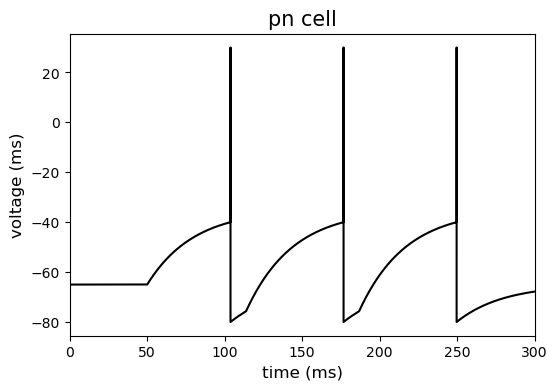

In [19]:
plt.figure(dpi=100)
plt.plot(nrn._times, cell_pn.vcells, 'k')
basic_labeling('pn cell')
plt.show()

### inhibitory neuron - PV

In [20]:
params_pv = {'tau':5, 'r':20, 'vth':-50, 'v0':-65, 'vmax':30, 'vahp':-80, 'ev':-65, 'tahp':0}
cell_pv = nrn.CellNetwork(**params_pv, Iext=Iext, target_id=[[0]], syn=False)
cell_pv.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 28195.54it/s]


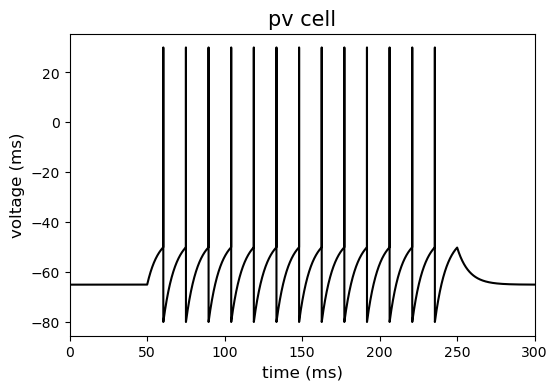

In [21]:
plt.figure(dpi=100)
plt.plot(nrn._times, cell_pv.vcells, 'k')
basic_labeling('pv cell')
plt.show()

### Poisson input

In [22]:
gext = nrn.gPoisson(0.1, 0.2, 5, delay=0, t0=100, t1=200) # p, tau_r, tau_d, 
eext = [0]
gbar = [[0.1]]
target_id = [[0]]

In [23]:
cell = nrn.CellNetwork(**params_pn, g_ext=gext, e_ext=eext, gbar_ext=gbar, target_id=target_id, syn=False)
cell.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 26666.68it/s]


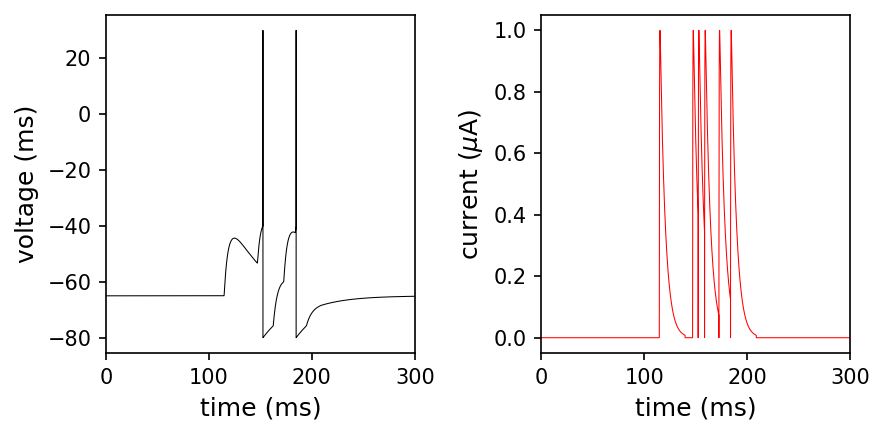

In [24]:
plt.figure(dpi=150, figsize=(6, 3))
plt.subplot(1,2,1)
plt.plot(nrn._times, cell.vcells, 'k', lw=0.5)
basic_labeling()
plt.subplot(1,2,2)
plt.plot(nrn._times[1:], gext, 'r', lw=0.5)
# plt.plot(nrn._times[1:], cell.ghat_ext[:, 0], 'r', lw=0.5)
basic_labeling()
plt.ylabel(r'current ($\mu$A)')
plt.tight_layout()
plt.show()

### Gaussian noise

In [25]:
cell = nrn.CellNetwork(**params_pn, Iext=Iext, target_id=[[0]], syn=False, std=0.5)
cell.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 27075.86it/s]


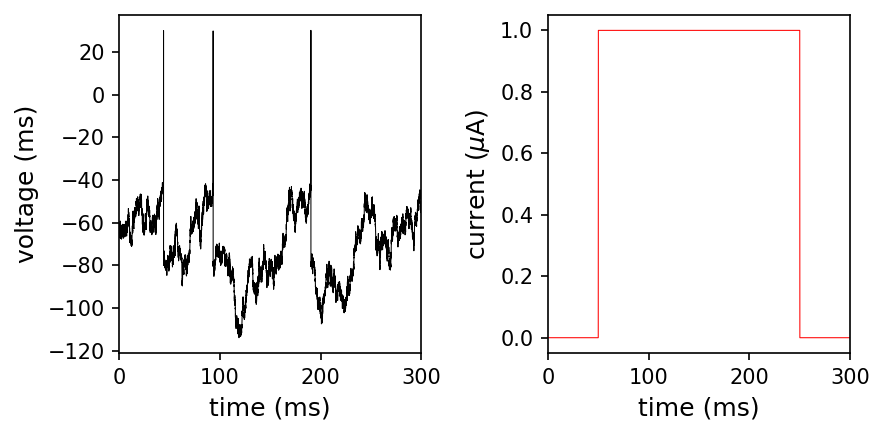

In [26]:
plt.figure(dpi=150, figsize=(6, 3))
plt.subplot(1,2,1)
plt.plot(nrn._times, cell.vcells, 'k', lw=0.5)
basic_labeling()
plt.subplot(1,2,2)
plt.plot(nrn._times[1:], Iext, 'r', lw=0.5)
basic_labeling()
plt.ylabel(r'current ($\mu$A)')
plt.tight_layout()
plt.show()

## two cell

### exc - exc

In [27]:
v0 = [-65, -65]
vth = [params_pn['vth'], params_pn['vth']]
vmax = [30, 30]
ev = [-65, -65]
tau = [params_pn['tau'], params_pn['tau']]
vahp = [-80, -80]
tahp = [10, 10]
r = [params_pn['r'], params_pn['r']]
# syn props
gbar_syn = [0.1]
tau_r = [0.3]
tau_d = [7]
B = nrn.get_syn_norm(tau_r, tau_d)
es = [0]
pre_id = [0]
post_id = [1]
# ext props
target_id = [[0]]

In [29]:
ntk = nrn.CellNetwork(v0=v0, vth=vth, vmax=vmax, vahp=vahp, ev=ev, tau=tau, r=r, tahp=tahp,
                      gbar_syn=gbar_syn, tau_r=tau_r, tau_d=tau_d, B=B, es=es, pre_id=pre_id, post_id=post_id,
                      Iext=Iext, target_id=target_id)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 17867.49it/s]


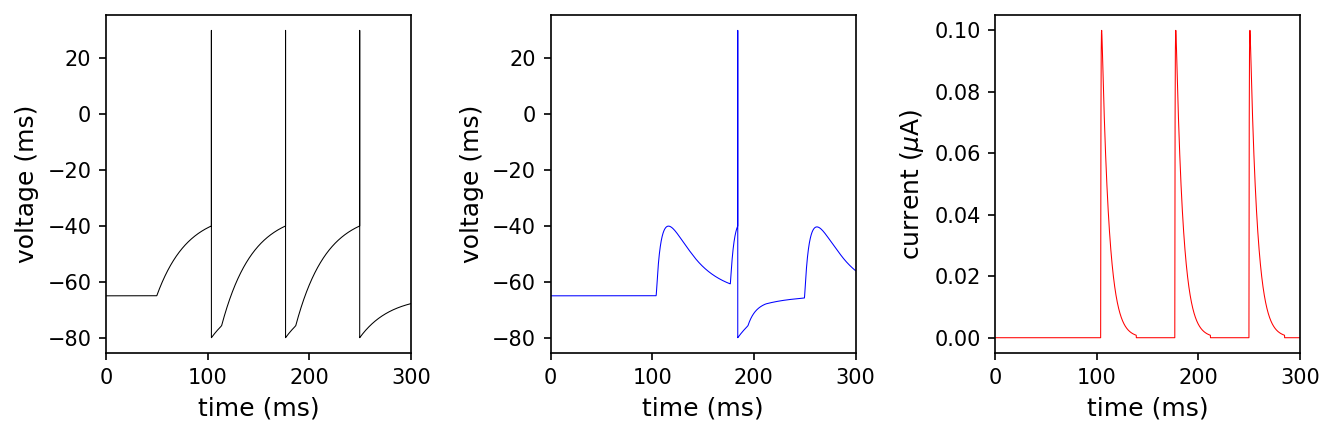

In [30]:
plt.figure(dpi=150, figsize=(9, 3))
plt.subplot(1,3,1)
plt.plot(nrn._times, ntk.vcells[:, 0], 'k', lw=0.5)
basic_labeling()
plt.subplot(1,3,2)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
basic_labeling()
plt.subplot(1,3,3)
plt.plot(nrn._times, ntk.g, 'r', lw=0.5)
basic_labeling()
plt.ylabel(r'current ($\mu$A)')
plt.tight_layout()
plt.show()

### exc - inh

In [32]:
v0 = [-65, -65]
vth = [params_pn['vth'], params_pv['vth']]
vmax = [30, 30]
ev = [-65, -65]
tau = [params_pn['tau'], params_pv['tau']]
r = [params_pn['r'], params_pv['r']]
vahp = [-80, -80]
tahp = [10, 0]
# syn props
gbar_syn = [0.05]
tau_r = [0.2]
tau_d = [5]
B = nrn.get_syn_norm(tau_r, tau_d)
es = [0]
pre_id = [0]
post_id = [1]
# ext props
target_id = [[0]]

In [33]:
ntk = nrn.CellNetwork(v0=v0, vth=vth, vmax=vmax, vahp=vahp, ev=ev, tau=tau, r=r, tahp=tahp,
                      gbar_syn=gbar_syn, tau_r=tau_r, tau_d=tau_d, B=B, es=es, pre_id=pre_id, post_id=post_id,
                      Iext=Iext, target_id=target_id)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 19557.13it/s]


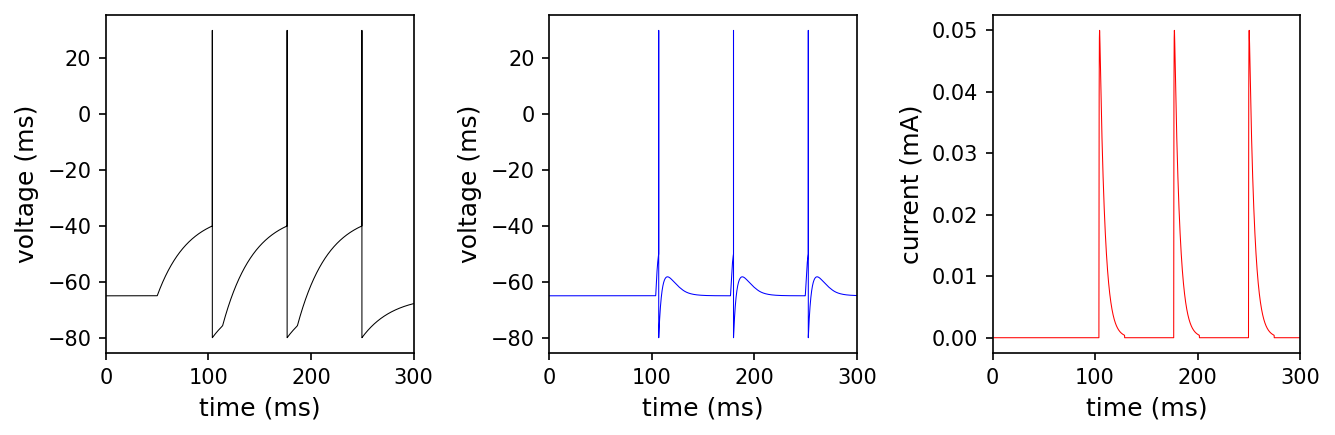

In [34]:
plt.figure(dpi=150, figsize=(9, 3))
plt.subplot(1,3,1)
plt.plot(nrn._times, ntk.vcells[:, 0], 'k', lw=0.5)
basic_labeling()
plt.subplot(1,3,2)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
basic_labeling()
# plt.xlim([100, 150])
plt.subplot(1,3,3)
plt.plot(nrn._times, ntk.g, 'r', lw=0.5)
basic_labeling()
plt.ylabel('current (mA)')
plt.tight_layout()
plt.show()

### inh - exc

In [35]:
Iext_inh = np.vstack((nrn.current_clamp(50, 200, 1), nrn.current_clamp(50, 200, 1.5)))
Iext_inh = Iext_inh.T

In [36]:
v0 = [-65, -65]
vth = [params_pv['vth'], params_pn['vth']]
vmax = [30, 30]
ev = [-65, -65]
tau = [params_pv['tau'], params_pn['tau']]
r = [params_pv['r'], params_pn['r']]
vahp = [-80, -80]
tahp = [0, 10]
# syn props
gbar_syn = [0.05]
tau_r = [0.1]
tau_d = [5]
B = nrn.get_syn_norm(tau_r, tau_d)
es = [-80]
pre_id = [0]
post_id = [1]
# ext props
target_id = [[0, 1]]

In [38]:
ntk = nrn.CellNetwork(v0=v0, vth=vth, vmax=vmax, vahp=vahp, ev=ev, tau=tau, r=r, tahp=tahp,
                      gbar_syn=gbar_syn, tau_r=tau_r, tau_d=tau_d, B=B, es=es, pre_id=pre_id, post_id=post_id,
                      Iext=Iext, target_id=target_id)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 15368.86it/s]


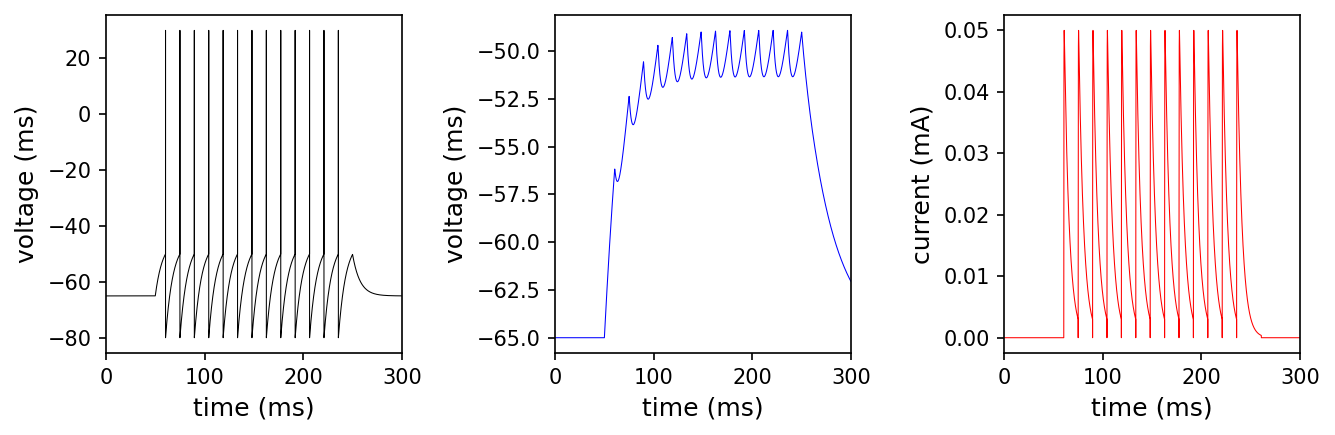

In [39]:
plt.figure(dpi=150, figsize=(9, 3))
plt.subplot(1,3,1)
plt.plot(nrn._times, ntk.vcells[:, 0], 'k', lw=0.5)
basic_labeling()
plt.subplot(1,3,2)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
basic_labeling()
# plt.xlim([100, 150])
plt.subplot(1,3,3)
plt.plot(nrn._times, ntk.g, 'r', lw=0.5)
basic_labeling()
plt.ylabel('current (mA)')
plt.tight_layout()
plt.show()

### two cells with white noise

In [40]:
Iext = nrn.current_clamp(50, 200, 1)

In [42]:
v0 = [-65, -65]
vth = [params_pn['vth'], params_pn['vth']]
vmax = [30, 30]
ev = [-65, -65]
tau = [params_pn['tau'], params_pn['tau']]
r = [params_pn['r'], params_pn['r']]
vahp = [-80, -80]
tahp = [10, 10]
# syn props
gbar_syn = [0.1]
tau_r = [0.2]
tau_d = [5]
B = nrn.get_syn_norm(tau_r, tau_d)
es = [0]
pre_id = [0]
post_id = [1]
# ext props
target_id = [[0]]
# standard deviation
std = 0.5

In [43]:
ntk = nrn.CellNetwork(v0=v0, vth=vth, vmax=vmax, vahp=vahp, ev=ev, tau=tau, r=r, tahp=tahp,
                      gbar_syn=gbar_syn, tau_r=tau_r, tau_d=tau_d, B=B, es=es, pre_id=pre_id, post_id=post_id,
                      Iext=Iext, target_id=target_id, std=std)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 18679.97it/s]


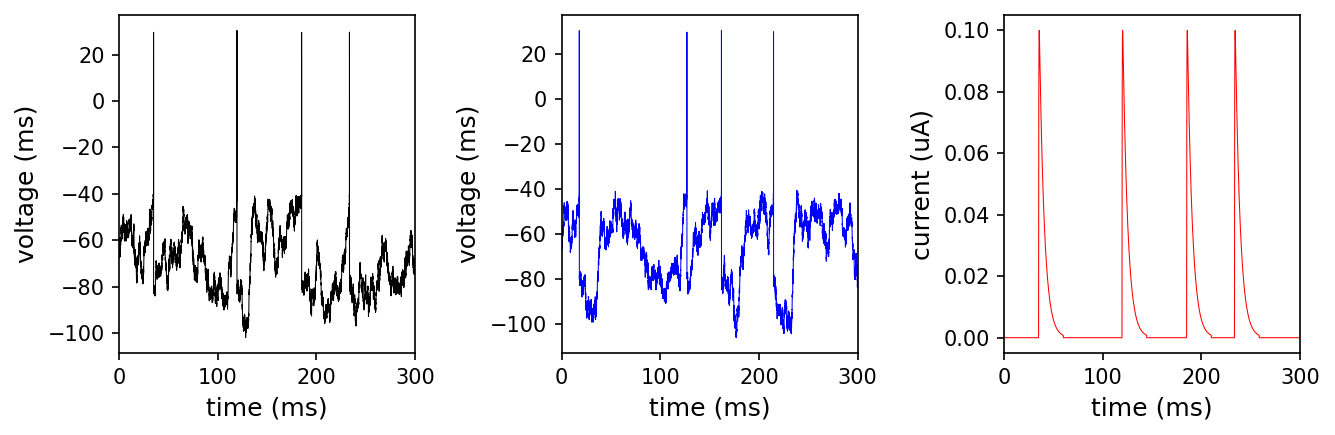

In [44]:
plt.figure(dpi=150, figsize=(9, 3))
plt.subplot(1,3,1)
plt.plot(nrn._times, ntk.vcells[:, 0], 'k', lw=0.5)
basic_labeling()
plt.subplot(1,3,2)
plt.plot(nrn._times, ntk.vcells[:, 1], 'b', lw=0.5)
basic_labeling()
# plt.xlim([100, 150])
plt.subplot(1,3,3)
plt.plot(nrn._times, ntk.g, 'r', lw=0.5)
basic_labeling()
plt.ylabel(r'current (uA)')
plt.tight_layout()
plt.show()

## PING

### two cell PING

In [96]:
params_pn = {'tau':20, 'r':30, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
params_pv = {'tau':5, 'r':20, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
syn_pn2pv = {'gbar_syn':0.5, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.5, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [97]:
amp_exc = 10
amp_inh = 0
i_exc = nrn.current_clamp(100, 200, amp_exc)
i_inh = nrn.current_clamp(100, 200, amp_inh)
i_all = np.array([i_exc, i_inh]).T
target_id = [[0], [1]]

In [98]:
cell_types = [0, 1]
adj_mat = [[-1, 0],
           [1, -1]]

In [99]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, adj_mat)

In [100]:
ping2 = nrn.CellNetwork(**setting, Iext=i_all, target_id=target_id, std=0.)
ping2.run()

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:03<00:00, 15342.06it/s]


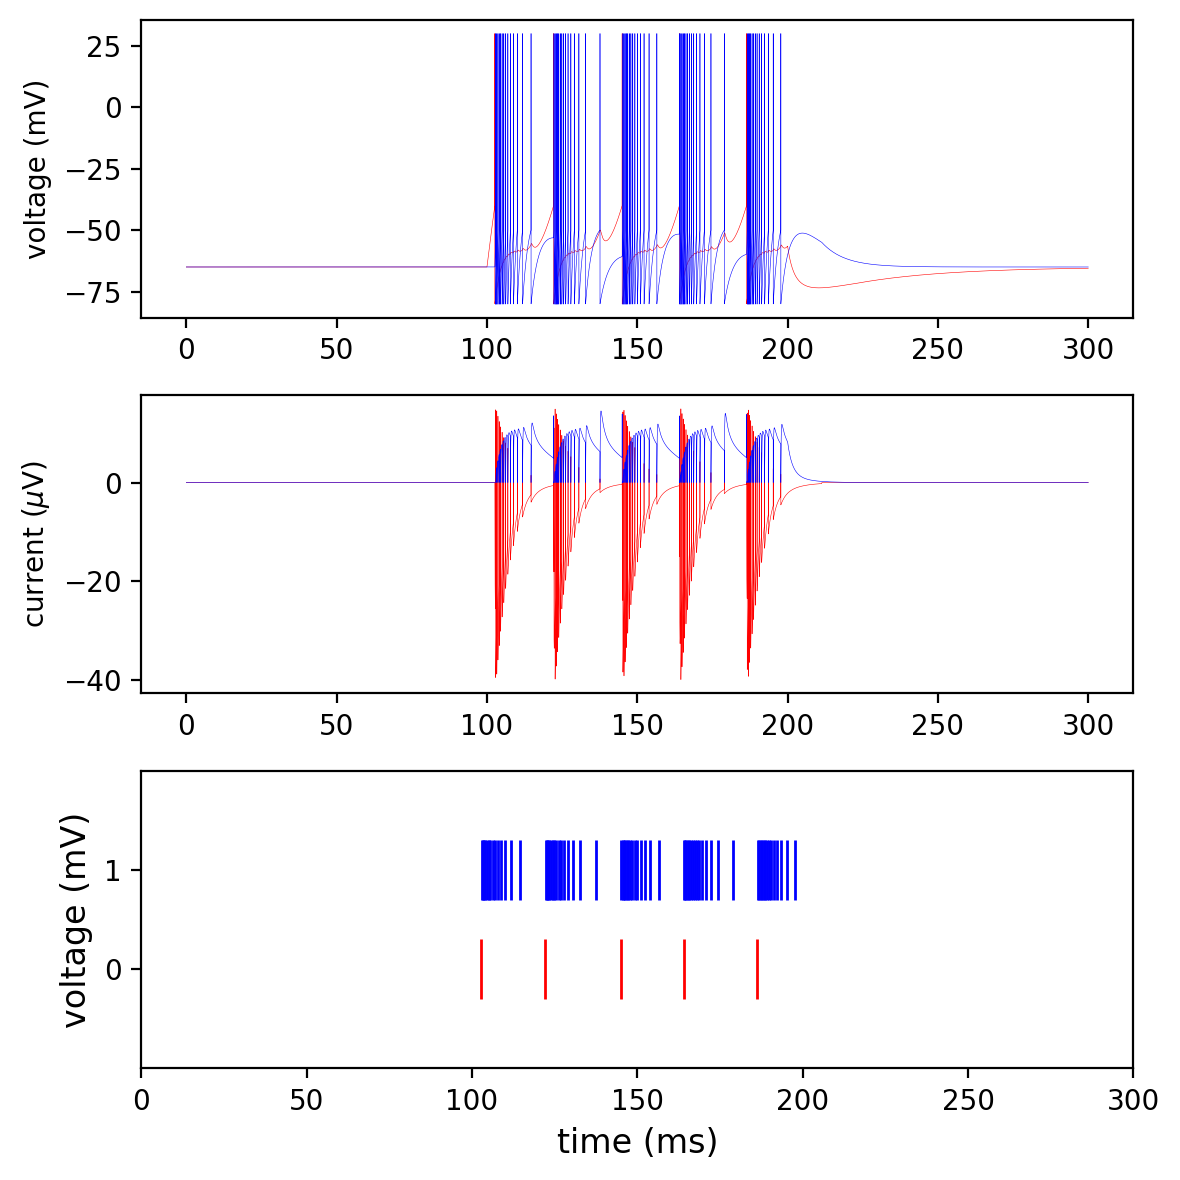

In [101]:
plt.figure(dpi=200, figsize=(6, 6))
cs = ['r', 'b']

plt.subplot(311)
for i in range(2):
    plt.plot(nrn._times, ping2.vcells[:, i], cs[i], lw=0.2)
plt.ylabel('voltage (mV)')

plt.subplot(312)
for i in range(2):
    plt.plot(nrn._times, ping2.isyns[:, i], cs[i], lw=0.2)
plt.ylabel(r'current ($\mu$V)')

plt.subplot(313)
for i in range(2):
    plt.vlines(ping2.spks[i], i-0.3, i+0.3, lw=1, color=cs[i])
basic_labeling()
plt.yticks([0, 1])
plt.ylim([-1, 2])

plt.tight_layout()
plt.show()

In [104]:
spk = np.array(ping2.spks[0])
fr = np.average(1e3 / (spk[1:] - spk[:-1]))
print(f'{fr} Hz')

48.07093425123815 Hz


### get firing rate of two cell PING model

In [49]:
nrn.set_times(tmax=200, dt=0.005)

In [50]:
amp_exc = 10
amp_inh = 0
# i_exc = nrn.current_clamp(0, 100, amp_exc)
i_inh = nrn.current_clamp(0, 100, amp_inh)
# i_all = np.array([i_exc, i_inh]).T
target_id = [[0], [1]]

In [36]:
params_pn = {'tau':20, 'r':30, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
params_pv = {'tau':5, 'r':20, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
syn_pn2pv = {'gbar_syn':0.5, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':1, 'tau_r':0.1, 'tau_d':5, 'es':-80}
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, adj_mat)

In [74]:
# change I, gbar_pn2pv
i_amp_list = np.linspace(0, 5, 20)
g_list = np.linspace(0, 2, 20)

frs = np.zeros([20, 20]) # i_amp_list, g_list
vs = np.zeros([nrn._nitr+1, 2, 20, 20])

for i, amp in enumerate(i_amp_list):
    for j, g in enumerate(g_list):
        
        i_exc = nrn.current_clamp(0, 100, amp)
        i_all = np.array([i_exc, i_inh]).T
        syn_pn2pv['gbar_syn'] = g
        setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pv, syn_pv2pn],
                         cell_types, adj_mat)
        ping2 = nrn.CellNetwork(**setting, Iext=i_all, target_id=target_id, std=0.)
        ping2.run()

        vs[:, :, i, j] = ping2.vcells
        if len(ping2.spks[0]) > 1:
            spk = np.array(ping2.spks[0])
            frs[i, j] = 1e3 / np.average(spk[1:] - spk[:-1])


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:02<00:00, 14460.48it/s]


In [83]:
print(i_amp_list[i])

1.3157894736842104


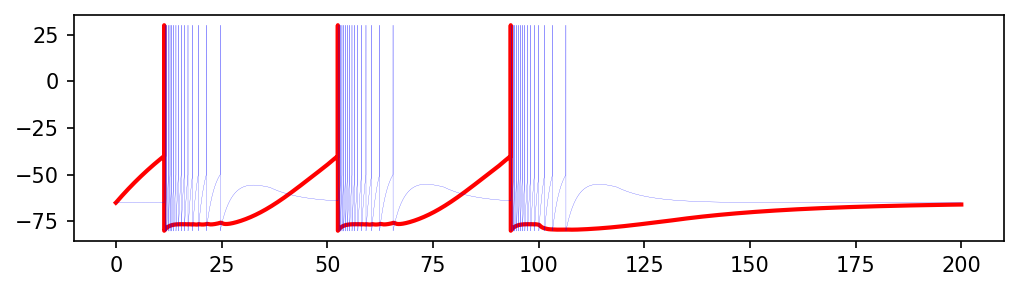

2.631578947368421 0.5263157894736842
24.394706348722323 Hz


In [88]:
i = 10 # amp
j = 5 # g

plt.figure(dpi=150, figsize=(8, 2))
plt.plot(nrn._times, vs[:, 0, i, j], 'r', lw=2)
plt.plot(nrn._times, vs[:, 1, i, j], 'b', lw=0.1)
# plt.plot(nrn._times, vs[:,:,i,j], lw=0.2)
plt.show()

print(i_amp_list[i], g_list[j])
print(f'{frs[i, j]} Hz')

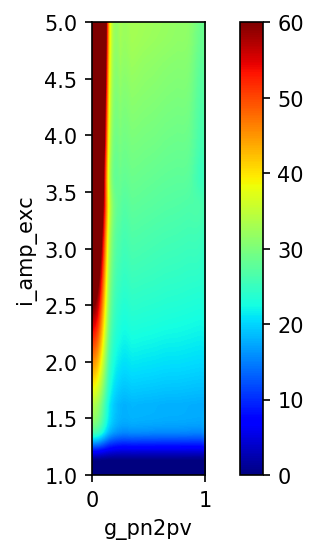

In [105]:
plt.figure(dpi=150)
plt.imshow(frs, origin='lower', extent=(0, 2, 0, 5), cmap='jet', vmax=60, interpolation='spline16')
plt.colorbar()
plt.xlim([0, 1])
plt.ylim([1, 5])
plt.xlabel('g_pn2pv')
plt.ylabel('i_amp_exc')
plt.show()

### Network

In [116]:
nrn.set_times(tmax=300, dt=0.005)

In [117]:
seed = 102107
nrn.set_seed(seed)

In [118]:
# create fully connected network
def create_network(n_exc, n_inh):
    # cell types
    ctypes = []
    for i in range(n_exc):
        ctypes.append(0)
    for i in range(n_inh):
        ctypes.append(1)
    # network
    n_cells = n_exc + n_inh
    num_gtypes = [[0, 1], [2, 3]]
    adj_mat = []
    for i in range(n_cells):
        ctype_pre = ctypes[i]
        adj_mat.append([])
        for j in range(n_cells):
            if i == j:
                adj_mat[i].append(-1)
            else:
                ctype_post = ctypes[j]
                adj_mat[i].append(num_gtypes[ctype_pre][ctype_post])
    return ctypes, adj_mat

### constant current

In [141]:
n_exc = 80
n_inh = 20
n_cells = n_exc + n_inh
# create cell types
cell_types, adj_mat = create_network(n_exc, n_inh)

In [142]:
amp_exc = 5
amp_inh = 1
i_exc = nrn.current_clamp(50, 250, amp_exc)
i_inh = nrn.current_clamp(50, 250, amp_inh)
i_all = np.array([i_exc, i_inh]).T
target_id = [[], []]
for n in range(n_cells):
    if n < n_exc:
        target_id[0].append(n)
    else:
        target_id[1].append(n)

In [143]:
params_pn = {'tau':20, 'r':30, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':20, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}
syn_pn2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pn2pv = {'gbar_syn':0.025, 'tau_r':0.1, 'tau_d':5, 'es':0}
syn_pv2pn = {'gbar_syn':0.00625, 'tau_r':0.1, 'tau_d':5, 'es':-80}
syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [144]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, adj_mat)

In [145]:
ntk = nrn.CellNetwork(**setting, Iext=i_all, target_id=target_id, std=0.1)
ntk.run()

MemoryError: Unable to allocate 4.43 GiB for an array with shape (60001, 9900) and data type float64

In [ ]:
cs = ['r', 'b']

plt.figure(dpi=150, figsize=(9, 6))
plt.subplot(2,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk.vcells[:, i], lw=0.5, c=cs[cell_types[i]], alpha=0.5)
basic_labeling()
plt.ylim([-180, 100])

plt.subplot(2,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling()
plt.ylabel('# spike')
# plt.yticks(list(range(1, n_exc+n_inh+1)))
plt.yticks(np.arange(0, n_cells, 10))

plt.tight_layout()
plt.show()

In [ ]:
vsum = np.average(ntk.vcells, 1)

In [ ]:
plt.figure(dpi=150, figsize=(8, 2))
plt.plot(nrn._times, vsum, 'k', lw=0.5)
basic_labeling()
plt.show()

In [39]:
fx = np.fft.fft(vsum) * nrn._dt
f = np.fft.fftfreq(len(vsum), nrn._dt/(1e3))
fx = abs(fx[:int(len(vsum)//2)])
f = f[:int(len(vsum)//2)]

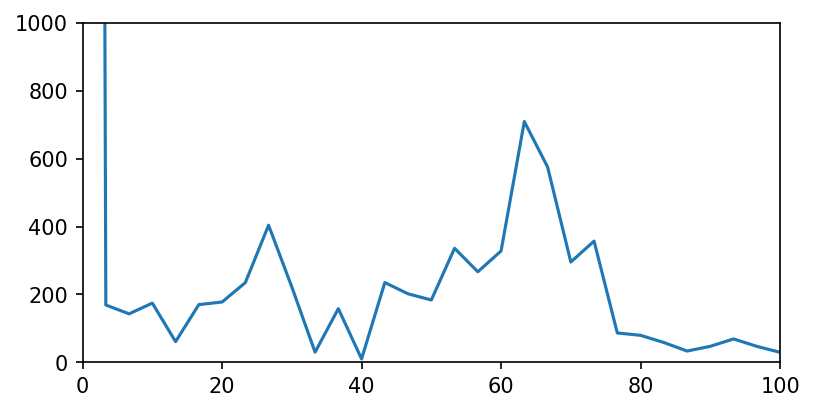

In [45]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(f, fx)
plt.xlim([0, 100])
plt.ylim([0, 1000])
plt.show()

### Poisson input

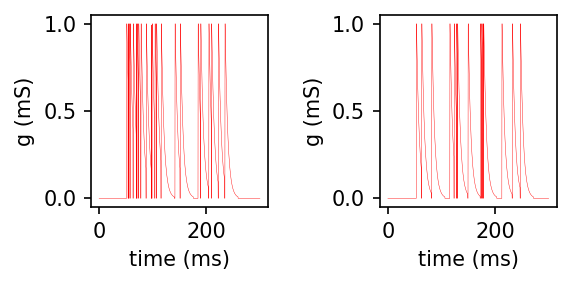

In [5]:
gbar_ext_inh = 0.1
gbar_ext_exc = 1
# p, tau_r, tau_d, delay
g1 = nrn.gPoisson(0.1, 0.1, 5, 0.5, t0=50, t1=250)
g2 = nrn.gPoisson(0.1, 0.1, 5, 0.5, t0=50, t1=250)
g_ext = np.vstack((g1, g2)).T
e_ext = [0, 0]
gbar_ext = [[gbar_ext_exc, gbar_ext_inh], [gbar_ext_exc, gbar_ext_inh]]
target_id = [[0, 2], [1, 3]]

plt.figure(dpi=150, figsize=(4, 2))
plt.subplot(121)
plt.plot(nrn._times[1:], g1, 'r', lw=0.2)
plt.xlabel('time (ms)')
plt.ylabel('g (mS)')
plt.subplot(122)
plt.plot(nrn._times[1:], g2, 'r', lw=0.2)
plt.xlabel('time (ms)')
plt.ylabel('g (mS)')
plt.tight_layout()
plt.show()


In [6]:
cell_types = [0, 0, 1, 1]
adj_mat = [[-1, 0, 1, 1],
           [0, -1, 1, 1],
           [2, 2, -1, 3],
           [2, 2, 3, -1]]

In [7]:
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, adj_mat)

In [8]:
ntk = nrn.CellNetwork(**setting, g_ext=g_ext, e_ext=e_ext, gbar_ext=gbar_ext, target_id=target_id, std=0.5)
ntk.run()

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12531.33it/s]


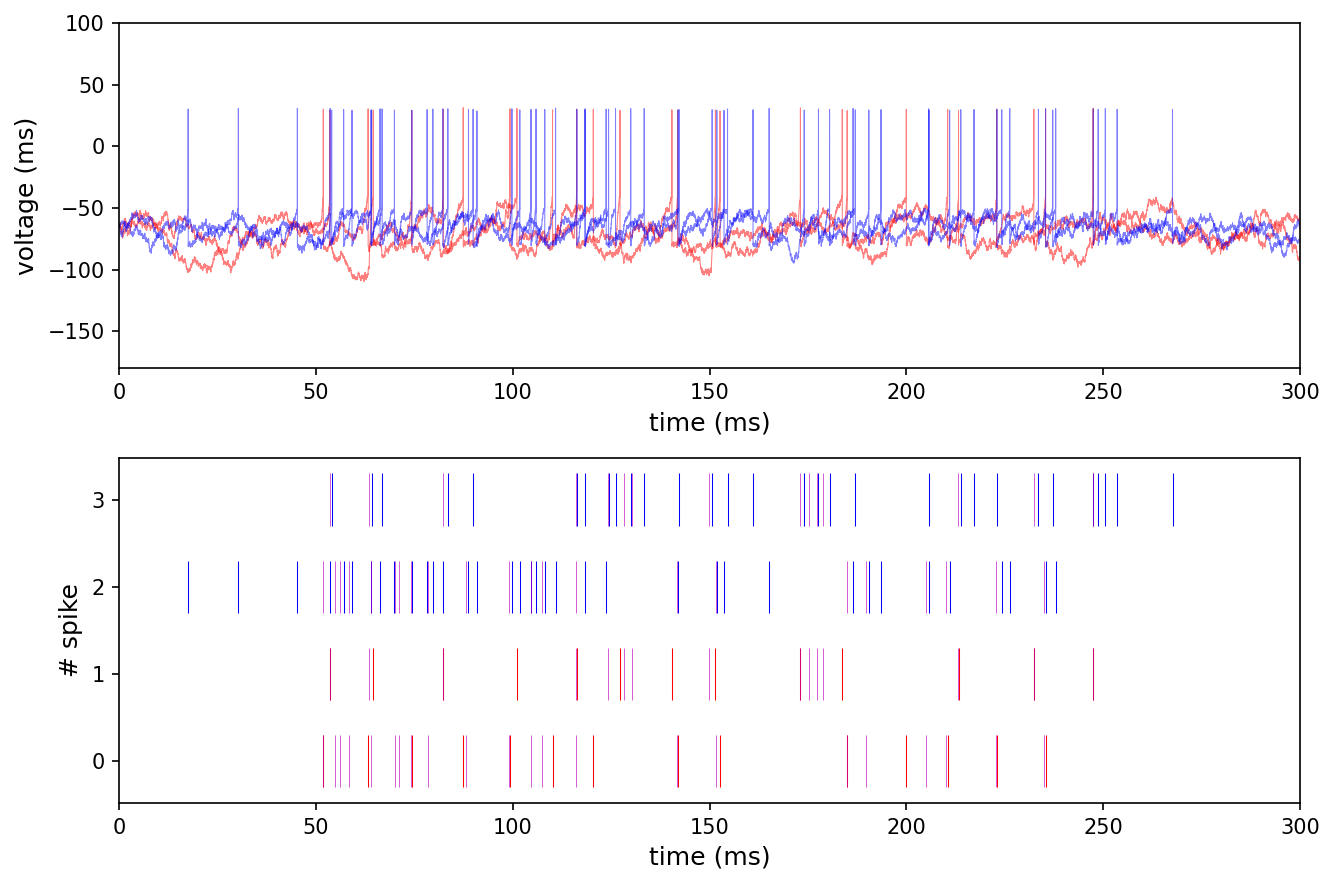

In [9]:
cs = []
for i in range(4):
    if cell_types[i] == 0:
        cs.append('r')
    else:
        cs.append('b')
        
plt.figure(dpi=150, figsize=(9, 6))
plt.subplot(2,1,1)
for i in range(4):
    plt.plot(nrn._times, ntk.vcells[:, i], lw=0.5, c=cs[i], label='exc', alpha=0.5)
# plt.plot(nrn._times, ntk.vcells[:, 3], 'b', lw=0.5, label='inh')
basic_labeling()
plt.ylim([-180, 100])

plt.subplot(2,1,2)
for i in range(4):
    plt.vlines(ntk.spks[i], i-0.3, i+0.3, color=cs[i], lw=0.5)
# plot Poisson signal - g1, g2
t1 = nrn._times[1:]
t1 = t1[g1 == 1]
t2 = nrn._times[1:]
t2 = t2[g2 == 1]
for n, t in enumerate([t1, t2]):
    for i in target_id[n]:
        plt.vlines(t, i-0.3, i+0.3, color='m', lw=0.3)
basic_labeling()
plt.ylabel('# spike')
plt.yticks([0,1,2,3])

plt.tight_layout()
plt.show()

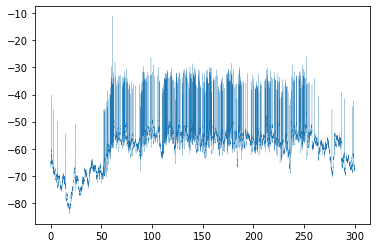

In [67]:
vsum = np.average(ntk.vcells, axis=1)
plt.plot(nrn._times, vsum, lw=0.2)
plt.show()